<a href="https://colab.research.google.com/github/aarohishaiva/CNN_final-Project/blob/main/FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
!pip install torch torchvision

# Install scikit-learn (for precision, recall, and F1-score calculations)
!pip install scikit-learn

# Install matplotlib (for plotting)
!pip install matplotlib

# Install tqdm (for progress bar)
!pip install tqdm

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.44MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.3MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training LeNet-5 Model on FMNIST Dataset:


100%|██████████| 469/469 [00:21<00:00, 21.55it/s]


Epoch [1/3], Train Loss: 0.5929, Test Loss: 0.4798, Accuracy: 0.8187, Precision: 0.8208, Recall: 0.8187, F1-score: 0.8183


100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


Epoch [2/3], Train Loss: 0.4140, Test Loss: 0.4249, Accuracy: 0.8415, Precision: 0.8449, Recall: 0.8415, F1-score: 0.8418


100%|██████████| 469/469 [00:25<00:00, 18.41it/s]


Epoch [3/3], Train Loss: 0.3696, Test Loss: 0.4029, Accuracy: 0.8523, Precision: 0.8552, Recall: 0.8523, F1-score: 0.8498


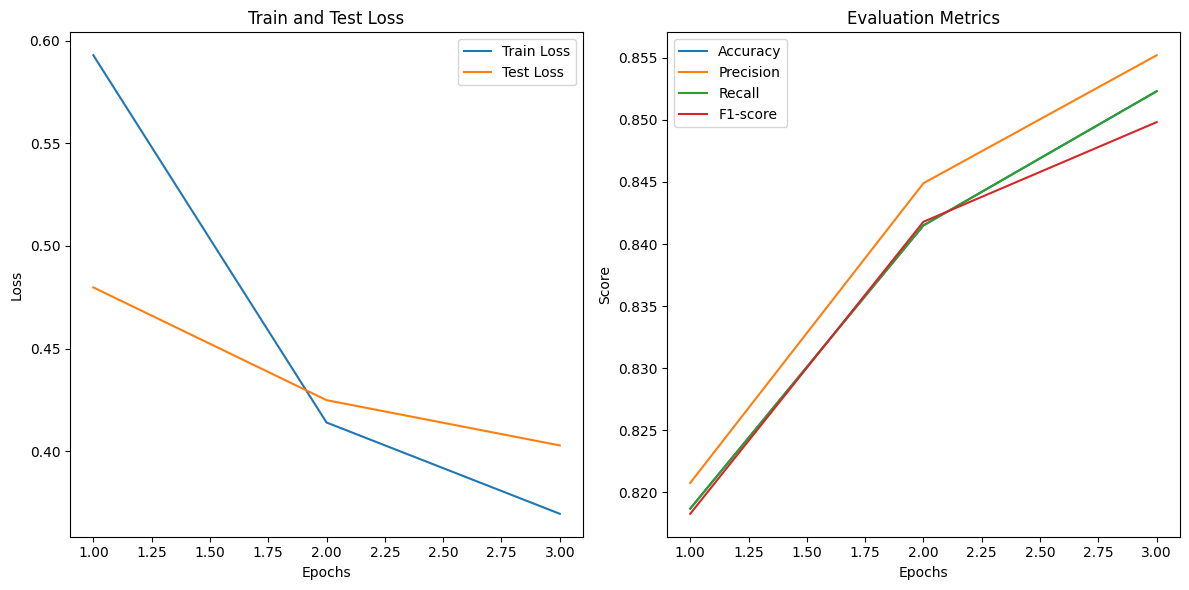

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set to use single thread for CPU operations (if necessary)
torch.set_num_threads(1)

# Adjusted LeNet-5 Model for 28x28 images
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Input: 1x28x28, Output: 6x24x24
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Output: 6x12x12

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Output: 16x8x8
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Output: 16x4x4

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjusted for 28x28 input
        self.act3 = nn.Tanh()

        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.Tanh()

        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.act3(self.fc1(x))
        x = self.act4(self.fc2(x))
        x = self.fc3(x)
        return x

# Load FMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Function (same as before)
def train_model(model, train_loader, test_loader, num_epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function (same as before)
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
lenet5_model = LeNet5()
print("Training LeNet-5 Model on FMNIST Dataset:")
train_losses, test_losses, metrics = train_model(lenet5_model, train_loader, test_loader, num_epochs=3)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


Training AlexNet Model on FMNIST Dataset:


100%|██████████| 469/469 [24:06<00:00,  3.08s/it]


Epoch [1/3], Train Loss: 0.6044, Test Loss: 0.3478, Accuracy: 0.8766, Precision: 0.8749, Recall: 0.8766, F1-score: 0.8737


100%|██████████| 469/469 [26:39<00:00,  3.41s/it]


Epoch [2/3], Train Loss: 0.3178, Test Loss: 0.3266, Accuracy: 0.8865, Precision: 0.8860, Recall: 0.8865, F1-score: 0.8851


100%|██████████| 469/469 [26:57<00:00,  3.45s/it]


Epoch [3/3], Train Loss: 0.2706, Test Loss: 0.2653, Accuracy: 0.9016, Precision: 0.9025, Recall: 0.9016, F1-score: 0.9017


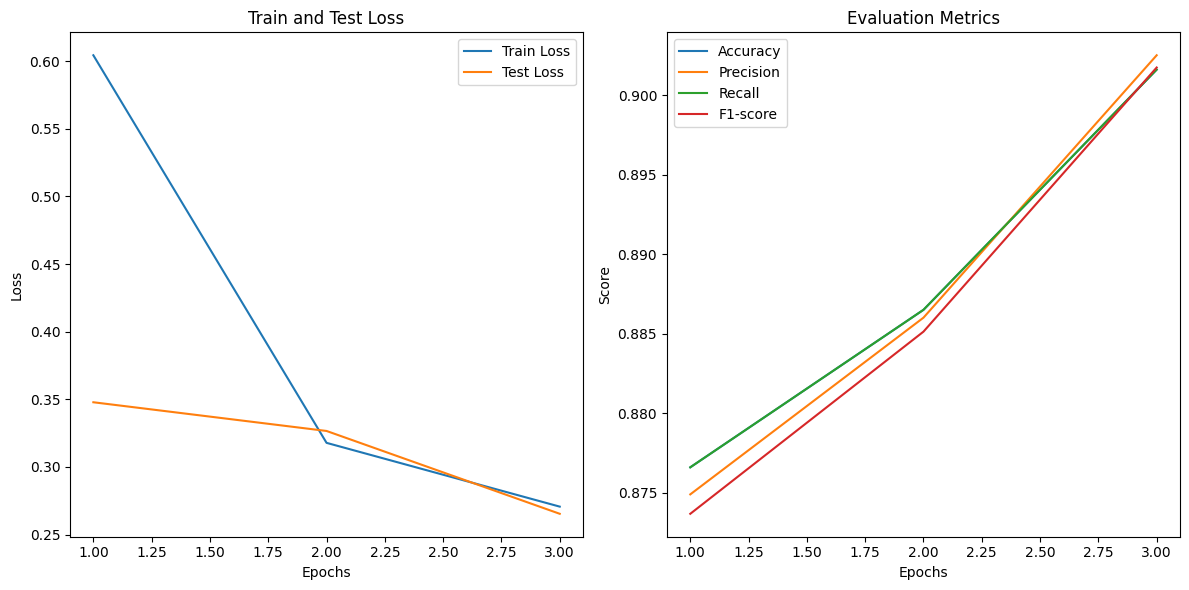

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Adjusted AlexNet Model for 28x28 images
class AlexNetModified(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetModified, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Input: 1x28x28, Output: 64x28x28
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 64x14x14

        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)  # Output: 192x14x14
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 192x7x7

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)  # Output: 384x7x7
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)  # Output: 256x7x7
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Output: 256x7x7
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 256x3x3

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 3 * 3, 4096)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool3(torch.relu(self.conv5(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Load FMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Function
def train_model(model, train_loader, test_loader, num_epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
alexnet_model = AlexNetModified()
print("Training AlexNet Model on FMNIST Dataset:")
train_losses, test_losses, metrics = train_model(alexnet_model, train_loader, test_loader, num_epochs=3)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


Training GoogleNet Model on FMNIST Dataset:


100%|██████████| 469/469 [11:27<00:00,  1.47s/it]


Epoch [1/3], Train Loss: 0.5939, Test Loss: 0.3874, Accuracy: 0.8539, Precision: 0.8544, Recall: 0.8539, F1-score: 0.8452


100%|██████████| 469/469 [13:48<00:00,  1.77s/it]


Epoch [2/3], Train Loss: 0.3472, Test Loss: 0.3354, Accuracy: 0.8746, Precision: 0.8763, Recall: 0.8746, F1-score: 0.8699


100%|██████████| 469/469 [14:24<00:00,  1.84s/it]


Epoch [3/3], Train Loss: 0.3008, Test Loss: 0.3109, Accuracy: 0.8873, Precision: 0.8883, Recall: 0.8873, F1-score: 0.8868


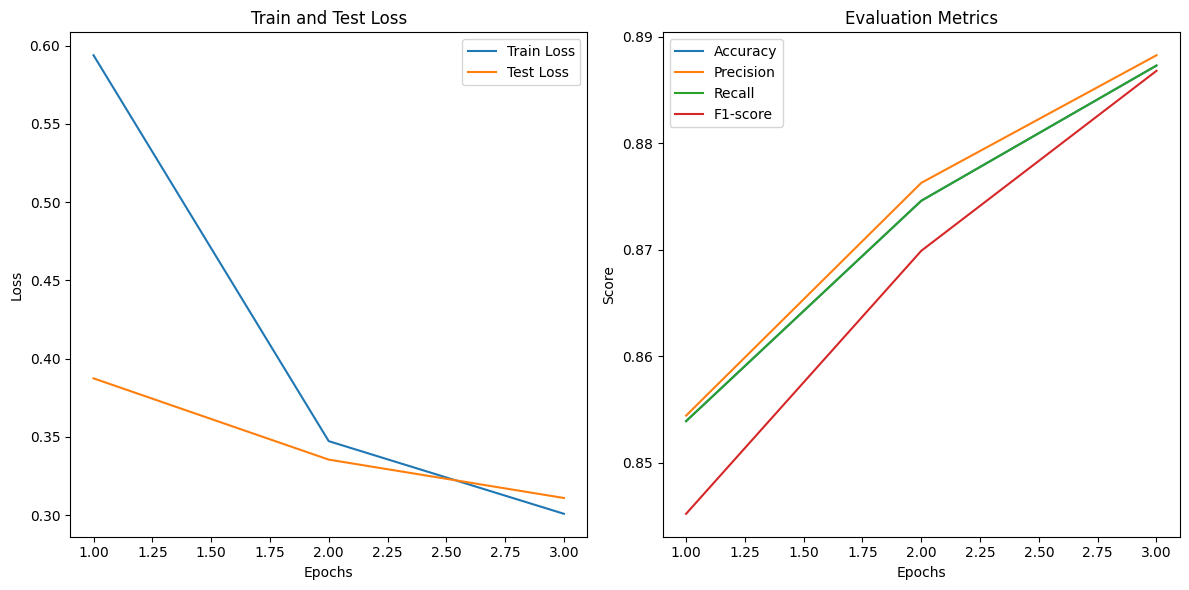

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Adjusted GoogleNet Model for 28x28 images
class GoogleNetModified(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogleNetModified, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)  # Input: 1x28x28, Output: 64x14x14
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Output: 64x7x7

        # Inception modules (simplified for FMNIST)
        self.inception1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),  # Output: 128x7x7
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Output: 128x7x7
            nn.ReLU(),
        )

        self.inception2 = nn.Sequential(
            nn.Conv2d(128, 192, kernel_size=1),  # Output: 192x7x7
            nn.ReLU(),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),  # Output: 192x7x7
            nn.ReLU(),
        )

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # Output: 192x4x4

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(192 * 4 * 4, 4096)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Load FMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Function
def train_model(model, train_loader, test_loader, num_epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
googlenet_model = GoogleNetModified()
print("Training GoogleNet Model on FMNIST Dataset:")
train_losses, test_losses, metrics = train_model(googlenet_model, train_loader, test_loader, num_epochs=3)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


Training VGGNet Model on FMNIST Dataset:


100%|██████████| 469/469 [33:41<00:00,  4.31s/it]


Epoch [1/3], Train Loss: 1.0104, Test Loss: 0.5028, Accuracy: 0.8211, Precision: 0.8180, Recall: 0.8211, F1-score: 0.8165


100%|██████████| 469/469 [36:54<00:00,  4.72s/it]


Epoch [2/3], Train Loss: 0.4154, Test Loss: 0.3539, Accuracy: 0.8670, Precision: 0.8662, Recall: 0.8670, F1-score: 0.8628


100%|██████████| 469/469 [36:43<00:00,  4.70s/it]


Epoch [3/3], Train Loss: 0.3287, Test Loss: 0.3147, Accuracy: 0.8855, Precision: 0.8845, Recall: 0.8855, F1-score: 0.8832


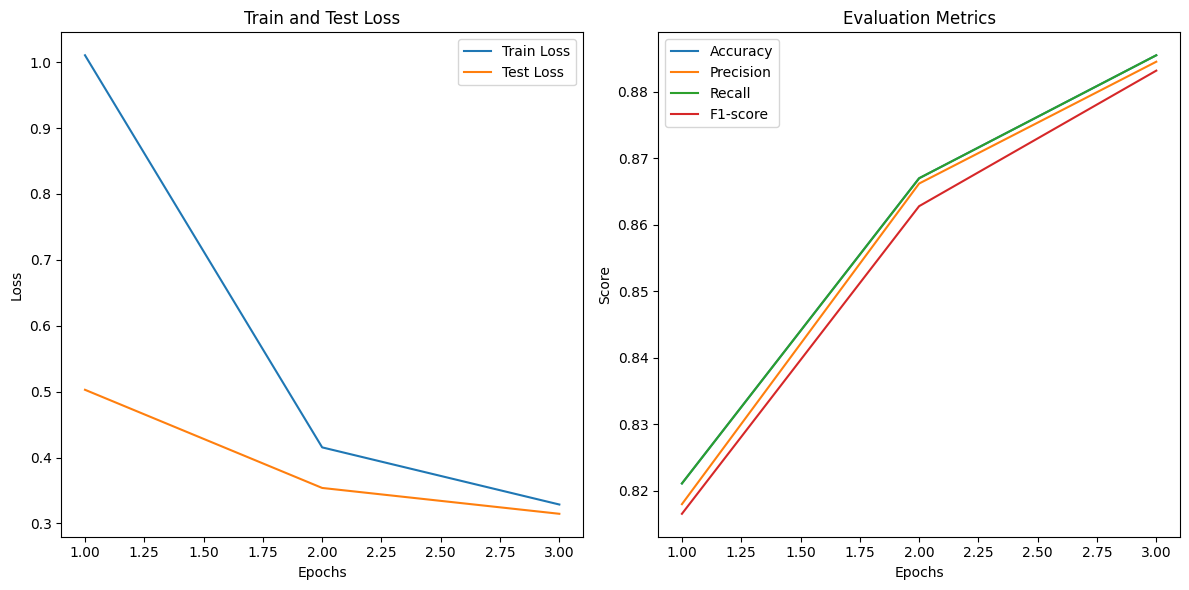

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Adjusted VGGNet Model for 28x28 images
class VGGNetModified(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGNetModified, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Input: 1x28x28, Output: 64x28x28
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Output: 64x28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),        # Output: 64x14x14

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 128x14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # Output: 128x14x14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),        # Output: 128x7x7

            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Output: 256x7x7
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Output: 256x7x7
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Output: 256x7x7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),        # Output: 256x3x3

            nn.Conv2d(256, 512, kernel_size=3, padding=1), # Output: 512x3x3
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Output: 512x3x3
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Output: 512x3x3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)         # Output: 512x1x1
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x

# Load FMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Function
def train_model(model, train_loader, test_loader, num_epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
vggnet_model = VGGNetModified()
print("Training VGGNet Model on FMNIST Dataset:")
train_losses, test_losses, metrics = train_model(vggnet_model, train_loader, test_loader, num_epochs=3)

# Plot the curves
plot_metrics(train_losses, test_losses, metrics)


100%|██████████| 26.4M/26.4M [00:07<00:00, 3.41MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 311kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.55MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.0MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training ResNet Model on FMNIST Dataset:


100%|██████████| 469/469 [1:00:23<00:00,  7.73s/it]


Epoch [1/3], Train Loss: 0.3860, Test Loss: 0.3154, Accuracy: 0.8846, Precision: 0.8878, Recall: 0.8846, F1-score: 0.8830


100%|██████████| 469/469 [59:26<00:00,  7.61s/it]


Epoch [2/3], Train Loss: 0.2381, Test Loss: 0.2409, Accuracy: 0.9123, Precision: 0.9123, Recall: 0.9123, F1-score: 0.9111


100%|██████████| 469/469 [58:47<00:00,  7.52s/it]


Epoch [3/3], Train Loss: 0.1951, Test Loss: 0.2146, Accuracy: 0.9218, Precision: 0.9224, Recall: 0.9218, F1-score: 0.9209


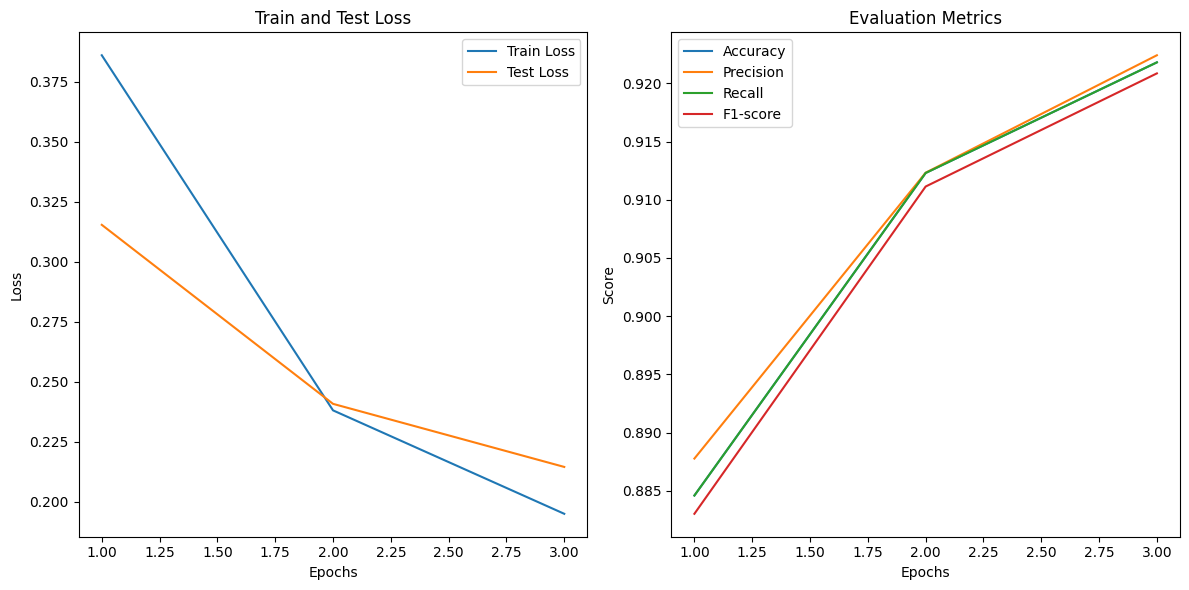

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define Basic Block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # Add shortcut
        out = self.relu(out)
        return out

# Define ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Input: 1x28x28
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        return x

# Load FMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Function
def train_model(model, train_loader, test_loader, num_epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
def main():
    num_blocks = [2, 2, 2, 2]  # Example configuration for ResNet-18
    resnet_model = ResNet(BasicBlock, num_blocks)
    print("Training ResNet Model on FMNIST Dataset:")
    train_losses, test_losses, metrics = train_model(resnet_model, train_loader, test_loader, num_epochs=3)

    # Plot the curves
    plot_metrics(train_losses, test_losses, metrics)

if __name__ == "__main__":
    main()


100%|██████████| 26.4M/26.4M [00:09<00:00, 2.84MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.23MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.38MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training Xception Model on FMNIST Dataset:


100%|██████████| 469/469 [21:01<00:00,  2.69s/it]


Epoch [1/3], Train Loss: 0.4502, Test Loss: 1.3560, Accuracy: 0.6325, Precision: 0.8060, Recall: 0.6325, F1-score: 0.6482


100%|██████████| 469/469 [20:59<00:00,  2.69s/it]


Epoch [2/3], Train Loss: 0.3148, Test Loss: 0.5449, Accuracy: 0.8257, Precision: 0.8597, Recall: 0.8257, F1-score: 0.8144


100%|██████████| 469/469 [21:00<00:00,  2.69s/it]


Epoch [3/3], Train Loss: 0.2673, Test Loss: 0.3158, Accuracy: 0.8887, Precision: 0.8934, Recall: 0.8887, F1-score: 0.8903


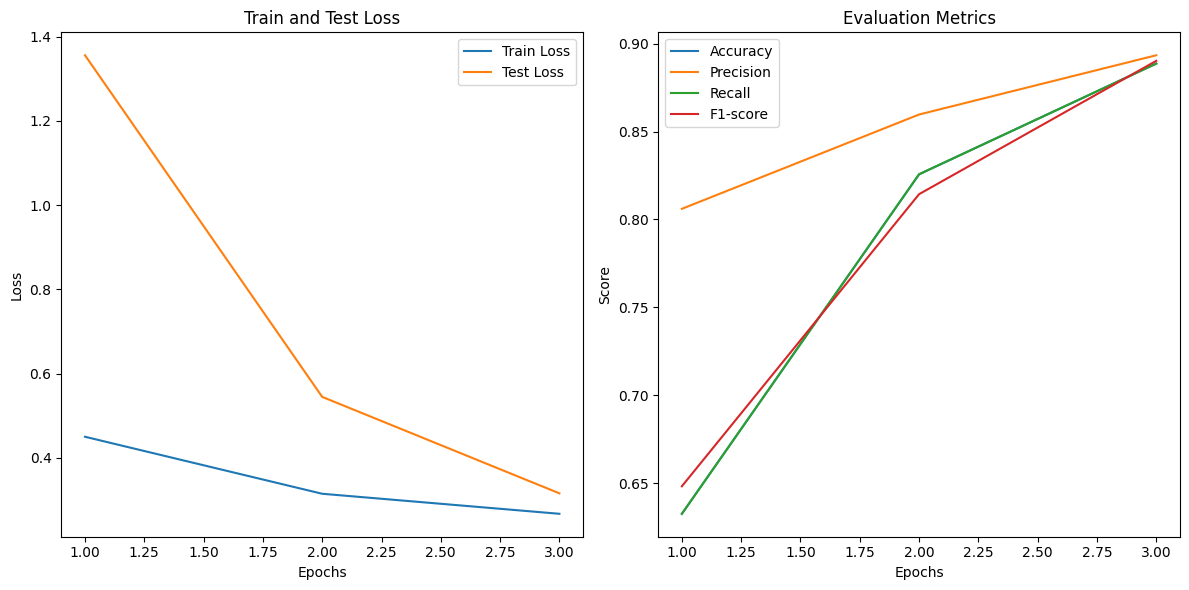

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define Depthwise Separable Convolution layer
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Define the Xception Block
class XceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, reps, stride=1, start_with_relu=True, grow_first=True):
        super(XceptionBlock, self).__init__()
        self.start_with_relu = start_with_relu
        self.reps = reps
        self.grow_first = grow_first
        self.skip = nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False) if stride != 1 or in_channels != out_channels else None
        self.bn_skip = nn.BatchNorm2d(out_channels)

        self.layers = nn.ModuleList()
        filters = in_channels
        if grow_first:
            self.layers.append(nn.ReLU())
            self.layers.append(SeparableConv2d(in_channels, out_channels, 3, stride=1, padding=1))
            filters = out_channels

        for _ in range(reps - 1):
            self.layers.append(nn.ReLU())
            self.layers.append(SeparableConv2d(filters, filters, 3, stride=1, padding=1))

        if not grow_first:
            self.layers.append(nn.ReLU())
            self.layers.append(SeparableConv2d(in_channels, out_channels, 3, stride=1, padding=1))

        if stride != 1:
            self.layers.append(nn.MaxPool2d(3, stride, 1))

    def forward(self, x):
        res = x
        if self.skip is not None:
            res = self.bn_skip(self.skip(x))
        for layer in self.layers:
            x = layer(x)
        x += res
        return x

# Define the Xception Model
class Xception(nn.Module):
    def __init__(self, num_classes=10):
        super(Xception, self).__init__()
        self.entry = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.middle_flow = nn.Sequential(
            XceptionBlock(64, 128, 2, stride=2),
            XceptionBlock(128, 256, 2, stride=2),
            XceptionBlock(256, 728, 2, stride=2)
        )

        self.exit_flow = nn.Sequential(
            XceptionBlock(728, 1024, 2, stride=2, grow_first=False),
            nn.Conv2d(1024, 1536, 3, padding=1, bias=False),
            nn.BatchNorm2d(1536),
            nn.ReLU(),
            nn.Conv2d(1536, 2048, 3, padding=1, bias=False),
            nn.BatchNorm2d(2048),
            nn.ReLU()
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.entry(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Load FMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Function
def train_model(model, train_loader, test_loader, num_epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
def main():
    xception_model = Xception()
    print("Training Xception Model on FMNIST Dataset:")
    train_losses, test_losses, metrics = train_model(xception_model, train_loader, test_loader, num_epochs=3)

    # Plot the curves
    plot_metrics(train_losses, test_losses, metrics)

if __name__ == "__main__":
    main()


Training SENet Model on FMNIST Dataset:


100%|██████████| 469/469 [13:27<00:00,  1.72s/it]


Epoch [1/3], Train Loss: 0.3779, Test Loss: 0.3067, Accuracy: 0.8860, Precision: 0.8901, Recall: 0.8860, F1-score: 0.8856


100%|██████████| 469/469 [13:27<00:00,  1.72s/it]


Epoch [2/3], Train Loss: 0.2380, Test Loss: 0.2670, Accuracy: 0.9026, Precision: 0.9026, Recall: 0.9026, F1-score: 0.9009


100%|██████████| 469/469 [13:18<00:00,  1.70s/it]


Epoch [3/3], Train Loss: 0.1907, Test Loss: 0.2253, Accuracy: 0.9175, Precision: 0.9179, Recall: 0.9175, F1-score: 0.9176


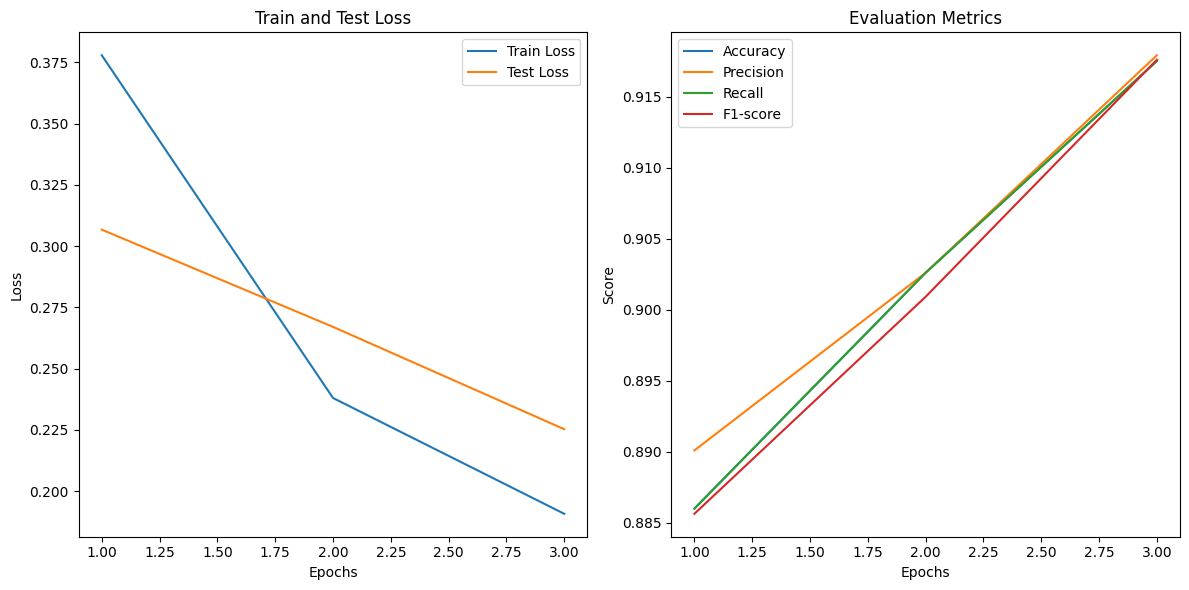

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.global_avg_pool(x)
        out = self.fc1(out)
        out = nn.ReLU()(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return x * out

# Define the SENet Block
class SENetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SENetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction=reduction)

        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False) if stride != 1 or in_channels != out_channels else None
        self.bn_skip = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = self.se(x)

        if self.skip is not None:
            residual = self.bn_skip(self.skip(residual))
        x += residual
        return nn.ReLU()(x)

# Define the SENet Model
class SENet(nn.Module):
    def __init__(self, num_classes=10):
        super(SENet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer2 = SENetBlock(64, 128, stride=2)
        self.layer3 = SENetBlock(128, 256, stride=2)
        self.layer4 = SENetBlock(256, 512, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Load FMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training Function
def train_model(model, train_loader, test_loader, num_epochs=3):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_losses.append(test_loss / len(test_loader))

        # Calculate Metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append Metrics
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    metrics = {
        "accuracy": accuracy_list,
        "precision": precision_list,
        "recall": recall_list,
        "f1_score": f1_list
    }
    return train_losses, test_losses, metrics

# Plotting Function
def plot_metrics(train_losses, test_losses, metrics):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train the Model
def main():
    senet_model = SENet()
    print("Training SENet Model on FMNIST Dataset:")
    train_losses, test_losses, metrics = train_model(senet_model, train_loader, test_loader, num_epochs=3)

    # Plot the curves
    plot_metrics(train_losses, test_losses, metrics)

if __name__ == "__main__":
    main()
